#  Setup

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from foraging import plotting
from foraging import utils
from matplotlib.lines import Line2D
from IPython.display import Markdown, display

import plotting.beliefs
import utils.beliefs
import utils.data
from plotting import BOX_LABELS, BOX_COLORS
from plotting import bp

# constants
SEED = 42
RNG = np.random.default_rng(SEED)
DATA_DIR = '../data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

The experiment data consists of multiple matfiles corresponding to the data for different subjects. Each matfile contains that subject's push, eye tracking (if available), and position (if available) data organized by blocks and sessions. Each block corresponds to a set of experiment parameters, notably the schedule of each box, the stimulus reliability kappa, and the stimulus type. A hierarchical overview of a given matfile is given in the `Angelaki Data Cleaning` notebook.

In [5]:
df = utils.data.make_dataframe(os.path.join(DATA_DIR, 'experiments'))
df = utils.data.exclusion_criteria(df)
display(Markdown(df.head()[["box", "push times", "reward outcomes"]].to_markdown()))

|                                                |   box |   push times | reward outcomes   |
|:-----------------------------------------------|------:|-------------:|:------------------|
| ('dylan', 1, 2, 1, 'probability', 1, 0.1, 'M') |     1 |        8.465 | False             |
| ('dylan', 1, 2, 2, 'probability', 1, 0.1, 'M') |     1 |        9.468 | False             |
| ('dylan', 1, 2, 3, 'probability', 1, 0.1, 'M') |     1 |       11.667 | False             |
| ('dylan', 1, 2, 4, 'probability', 1, 0.1, 'M') |     2 |       17.125 | False             |
| ('dylan', 1, 2, 5, 'probability', 1, 0.1, 'M') |     2 |       19.904 | False             |

## Data Overview
A quick overview of the summary statistics

In [6]:
print("schedules experienced by each subject")
print(df.groupby('subject')['schedule'].unique())

schedules experienced by each subject
subject
dylan                      [15.0, 21.0, 35.0]
humans                      [21.0, 7.0, 14.0]
marco                [15.0, 21.0, 35.0, 30.0]
viktor    [21.0, 35.0, 15.0, 7.0, 14.0, 28.0]
Name: schedule, dtype: object


<Axes: xlabel='subject', ylabel='n pushes per block'>

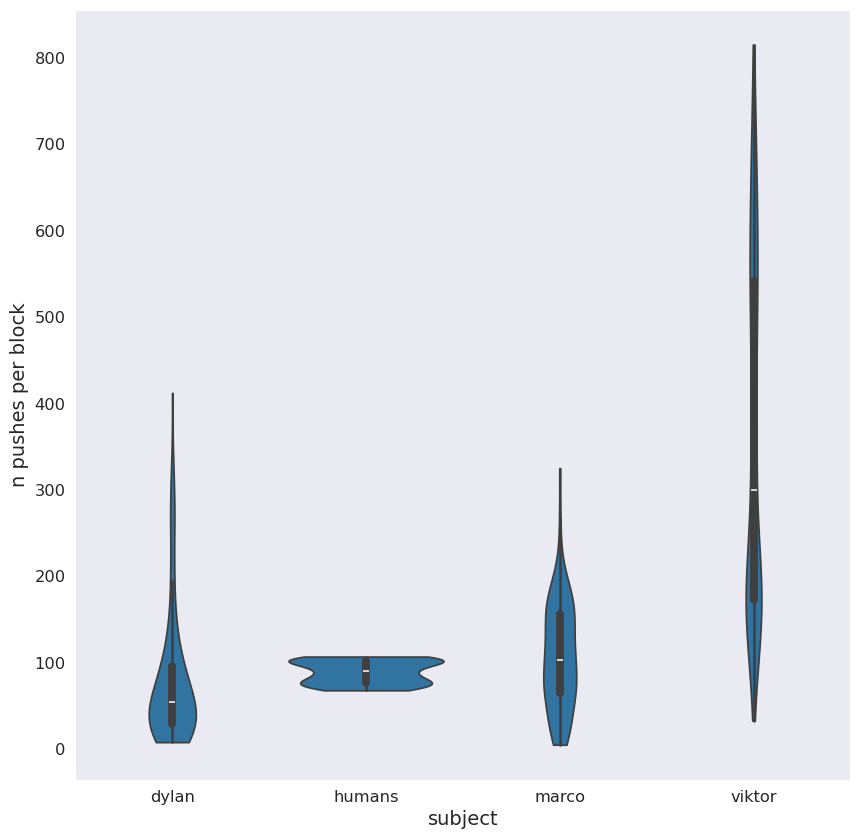

In [7]:
n_pushes_per_block = df.groupby(['subject', 'session', 'block']).size().reset_index(name='n pushes per block')
fig, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(n_pushes_per_block, x='subject', y='n pushes per block', cut=0, ax=ax)

In [173]:
summary = n_pushes_per_block.groupby('subject')['n pushes per block'].agg(['min', 'max', 'mean', 'std'])
print("summary of # pushes per block by subject")
print(summary)

summary of # pushes per block by subject
         min  max        mean         std
subject                                  
dylan      6  414   82.331325   76.635808
humans    69  108   90.238095   13.251433
marco      4  326  110.300971   61.397266
viktor    10  816  357.690691  204.248395


# Push Interval Statistics

Text(40.000000000000014, 0.5, 'consecutive push intervals (s)')

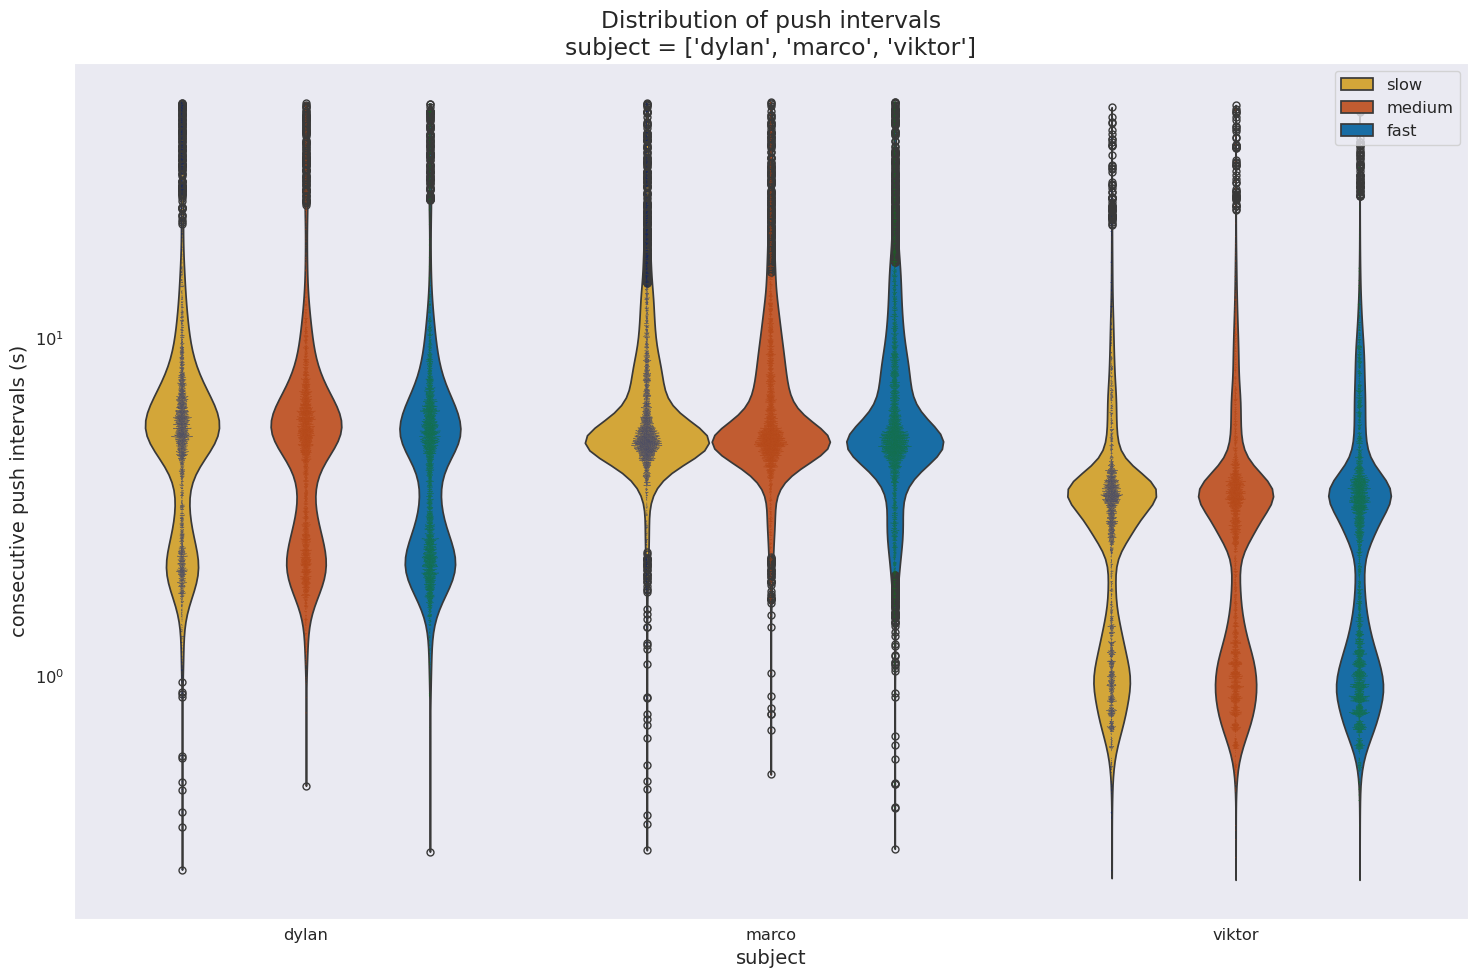

In [8]:
# Examine monkeys separately from humans
conds = {'subject': ['dylan', 'marco', 'viktor']}
df_monkey = utils.data.filter_df(df, conds).copy(deep=True)

# Plot distribution of push intervals on log-scale
fig, ax = plt.subplots()
bp(sns.boxplot)(df_monkey, conds=conds, x='subject', y='consecutive push intervals', collapse=True, showcaps=False,
                showbox=False, log_scale=True, whiskerprops={'visible': False}, medianprops={'visible': False},
                legend=False, ax=ax)
bp(sns.swarmplot)(df_monkey.groupby('subject').sample(10000, random_state=SEED), conds=conds, x='subject',
                  y='consecutive push intervals', collapse=True, legend=False, log_scale=True, size=0.5, dodge=True,
                  palette='dark', ax=ax)
bp(sns.violinplot)(df_monkey, conds=conds, x='subject', y='consecutive push intervals', collapse=True, cut=0,
                   inner=None, log_scale=True, common_norm=True, title_prefix="Distribution of push intervals", ax=ax)
ax.set_ylabel(ax.get_ylabel() + ' (s)')

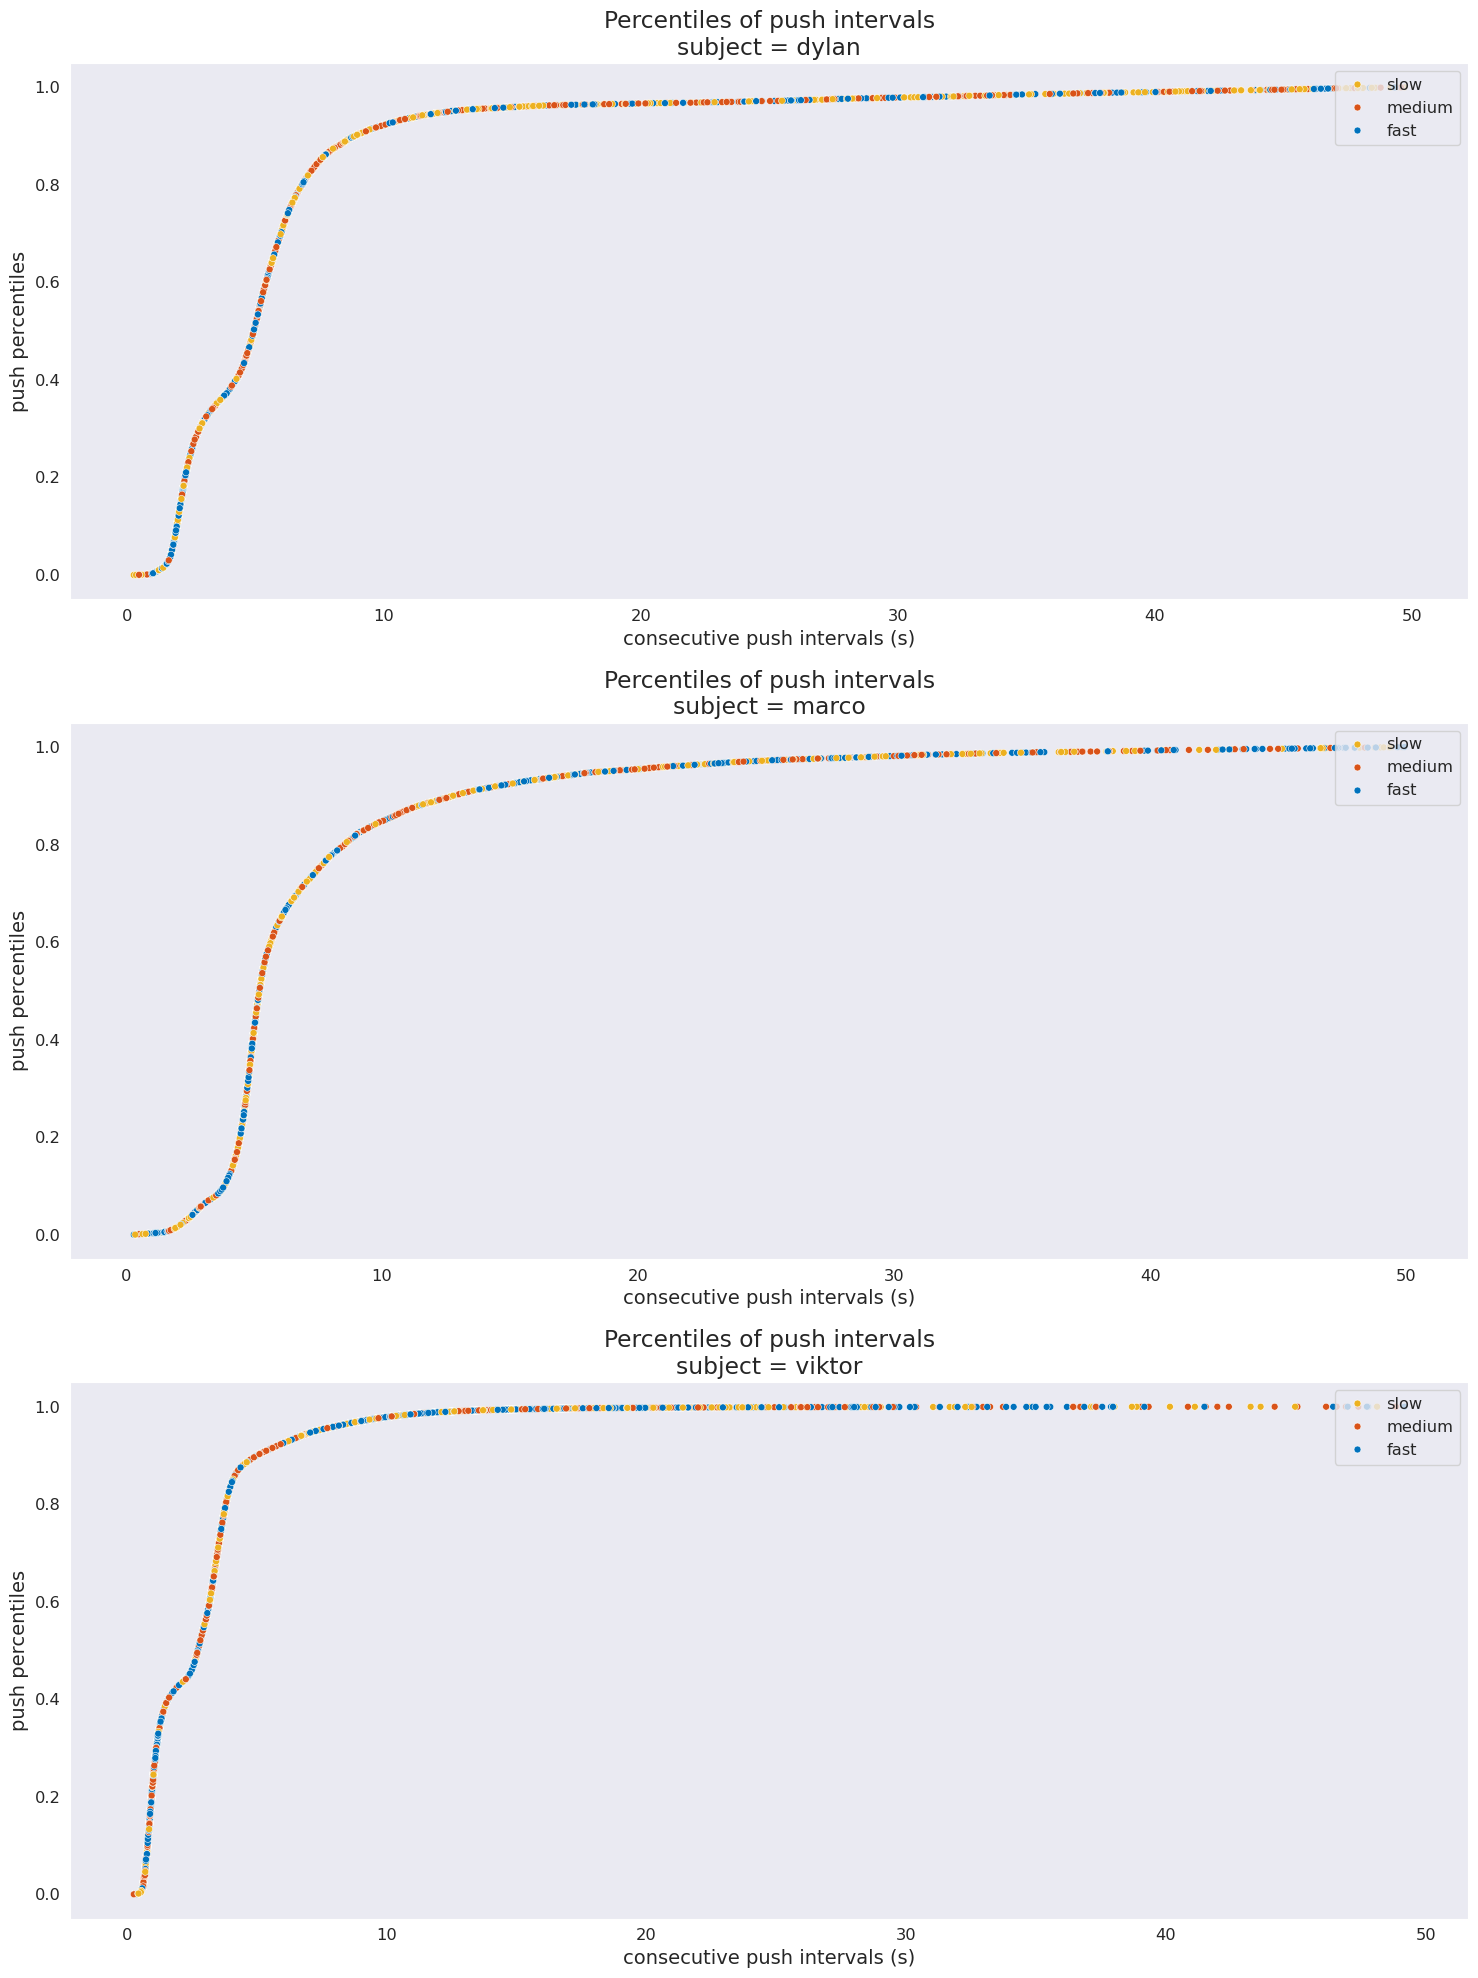

In [9]:
df_monkey['push percentiles'] = df_monkey.groupby('subject', as_index=False)['consecutive push intervals'].rank(
    pct=True)
monkey_subjects = df_monkey.index.unique('subject')
monkey_knees = {}
fig, axes = plt.subplots(len(monkey_subjects), 1, figsize=(15, 20))
for i, subj in enumerate(monkey_subjects):
    bp(sns.scatterplot)(df_monkey, x='consecutive push intervals', y='push percentiles', collapse=True,
                        conds={'subject': subj}, title_prefix="Percentiles of push intervals", ax=axes[i])
    y = df_monkey.loc[(subj,), 'push percentiles'].sort_values()
    x = df_monkey.loc[(subj,), 'consecutive push intervals'].sort_values()
    axes[i].set_xlabel(axes[i].get_xlabel() + ' (s)')
fig.tight_layout()